# Estimating HANK


In [76]:
import numpy as np
from scipy import optimize, signal
import pandas as pd
import numba
import matplotlib.pyplot as plt

import sequence_jacobian as sj

Extra routines for simulation, computing priors, and historical shock decomposition of time series:

In [77]:
"""Core utilities for simulation, second moments, and estimation"""

def simulate(impulses, outputs, T_sim):
    """
    impulses: list of ImpulseDicts, each an impulse to independent unit normal shock
    outputs: list of outputs we want in simulation
    T_sim: length of simulation

    simulation: dict mapping each output to length-T_sim simulated series
    """

    simulation = {}
    epsilons = [np.random.randn(T_sim + impulses[0].T - 1) for _ in impulses]
    for o in outputs:
        simulation[o] = sum(simul_shock(imp[o], eps) 
                            for imp, eps in zip(impulses, epsilons))
        
    return simulation

@numba.njit(parallel=True)
def simul_shock(dX, epsilons):
    """Take in any impulse response dX to epsilon shock, plus path of epsilons, and simulate"""    
    # if I have T_eps epsilons, can simulate length T_eps - T + 1 dXtildes
    # by indexing as eps_(-T-1), ... , eps_(T_eps-T+1) and implementing formula
    T = len(dX)
    T_eps = len(epsilons)
    dXtilde = np.empty(T_eps - T + 1) 
    
    dX_flipped = dX[::-1].copy() # flip because dX_s multiplies eps_(t-s)
    for t in numba.prange(T_eps - T + 1):
        dXtilde[t] = np.vdot(dX_flipped, epsilons[t:t + T]) # sum as single dot product

    return dXtilde


"""Log-likelihood of priors"""

def log_priors(thetas, priors_list):
    """Given a vector 'thetas', where entry i is drawn from the prior
    distribution specified in entry i of priors_list, calculate sum of
    log prior likelihoods of each theta. Distributions over theta should be specified 
    in the same way that arguments are given to the 'log_prior' function: first the
    name of the family, and then two parameters"""
    return sum(log_prior(theta, *prior) for theta, prior in zip(thetas, priors_list))


def log_prior(theta, dist, arg1, arg2):
    """Calculate log prior probability of 'theta', if prior is from family
    'dist' with parameters 'arg1' and 'arg2' (depends on prior)"""
    if dist == 'Normal':
        mu = arg1
        sigma = arg2
        return - 0.5 * ((theta - mu)/sigma)**2
    elif dist == 'Uniform':
        lb = arg1
        ub = arg2
        return - np.log(ub-lb)
    elif dist == 'Invgamma':
        s = arg1
        v = arg2
        return (-v-1) * np.log(theta) - v*s**2/(2*theta**2)
    elif dist == 'Gamma':
        theta = arg2**2 / arg1
        k = arg1 / theta
        return (k-1) * np.log(theta) - theta/theta
    elif dist == 'Beta':
        alpha = (arg1*(1 - arg1) - arg2**2) / (arg2**2 / arg1)
        beta = alpha / arg1 - alpha
        return (alpha-1) * np.log(theta) + (beta-1) * np.log(1-theta)
    else:
        raise ValueError('Distribution provided is not implemented in log_prior!')




Finally, we'll import a standard HA Model with real bonds, a gradual tax adjustment rule in response to fiscal shocks, and a Taylor rule for monetary policy. For details, you can look at the (brief) specification of the model in `estimation/model.py`.

In [78]:
"""
This HA model combines SIM, a Taylor rule for monetary policy
with a gradual tax adjustment rule and real bonds on the fiscal side
"""

import numpy as np
import sequence_jacobian as sj

"""Simple household block"""

hh = sj.hetblocks.hh_sim.hh
make_grids = sj.hetblocks.hh_sim.make_grids

def income(Y, T, e_grid):
    # post-tax labor income
    y = (Y-T) * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])


"""Inflation, monetary, and fiscal"""

@sj.simple
def nkpc(pi, Y, X, C, kappa_w, vphi, frisch, markup_ss, eis, beta):
    piw = pi + X - X(-1)
    # note: for simplicity, we ignore distortionary effect of taxation here
    piwres = kappa_w * (vphi*(Y/X)**(1/frisch) - 1/markup_ss * X * C**-(1/eis)) + beta * piw(1) - piw
    return piwres, piw


@sj.simple
def monetary_taylor(pi, ishock, rss, phi_pi):
    i = rss + phi_pi * pi + ishock
    r_ante = i - pi(1)
    return i, r_ante


@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r


@sj.solved(unknowns={'B': (-1., 1.)}, targets=['Bres'], solver="brentq")
def fiscal_deficit_Trule(r, G, B, Tss, phi_T, Y):
    T = Tss + phi_T * (B(-1) - B.ss)
    Bres = (1 + r) * B(-1) + G - T - B
    return T, Bres


"""Overall model"""

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt


ha = sj.create_model([household_simple, nkpc, monetary_taylor, ex_post_rate, fiscal_deficit_Trule, mkt_clearing],
                     name="Simple HA Model")

## Calibration and model setup

In [79]:
calibration = {'eis': 0.5,  # elasticity of intertemporal substitution
               'frisch': 0.5,  # labor supply elasticity
               'markup_ss': 1.015,  # steady state markup
               'phi_pi': 1.5,  # Taylor coefficient on inflation
               'kappa_w': 0.2,  # slope of the wage Phillips curve
               'phi_T': 0.1,  # adjustment coefficient in tax rule
               'rho_e': 0.92,  # persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,  # standard deviation fo idiosyncratic productivity shocks
               'n_e': 11,  # number of productivity grid points
               'min_a': -1,  # minimum asset level on the grid
               'max_a': 1000,  # maximum asset level on the grid
               'n_a': 500,  # number of asset grid points
               'X': 1.,  # TFP
               'G': 0.,  # exogenous government spending
               'B': 0.,  # government debt level
               'Tss': 0.,  # steady state government taxes
               'ishock': 0.}  # monetary policy shock

# Steady state values for endogenous variables
calibration['r'] = calibration['rss'] = 0.01
calibration['pi'] = 0.
calibration['Y'] = 1.

In [80]:
unknowns_ss = {"beta": 0.8, "vphi": 0.8}
targets_ss = ["asset_mkt", "piwres"]
ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss)

In [81]:
ss['beta']

0.8233548425126794

We'll assume that the Taylor rule intercept `ishock`, the TFP parameter `X`, and government spending `G` all follow AR(1) processes, and we'll be interested in what happens to three outcome variables: inflation `pi`, output `Y`, and the nominal interest rate `i`.

First, let's solve for the GE Jacobian of these outcomes with respect to the inputs that are shocked. This will prove useful later as well.

In [82]:
unknowns = ['Y', 'pi']
targets = ['asset_mkt', 'piwres']
inputs = ['ishock', 'X', 'G']
outputs = ['pi', 'Y', 'i']
T = 500

G = ha.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

Now we'll specify the persistences and standard deviation of the shocks, calculate the impulse response of each shocked variable to its one-standard-deviation innovation, and then compose each with `G` to get the impulse responses of the outcome variables, for which we'll maintain a list.

In [83]:
sigmas = {'ishock': 1, 'X': 0.5, 'G': 0.2}
rhos = {'ishock': 0.7, 'X': 0.8, 'G': 0.7}
impulses = {}
for i in inputs:
    own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)} 
    impulses[i] = G @ own_shock


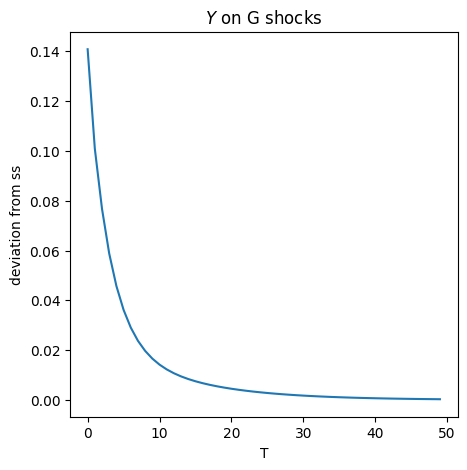

In [84]:

fig, axs = plt.subplots(1,1,figsize=(5, 5))

axs.plot(impulses['G']['Y'][0:50]) # IRF shock of G on Y
axs.set_title(r'$Y$ on G shocks')
axs.set_ylabel(r'deviation from ss')
axs.set_xlabel(r'T')
plt.show()

Now if we feed the list of impulse responses to our independent shocks to our `simulate` function, it will give us simulations of whatever length we want.

Simulation a la Boppart, Krussel, Mitman:

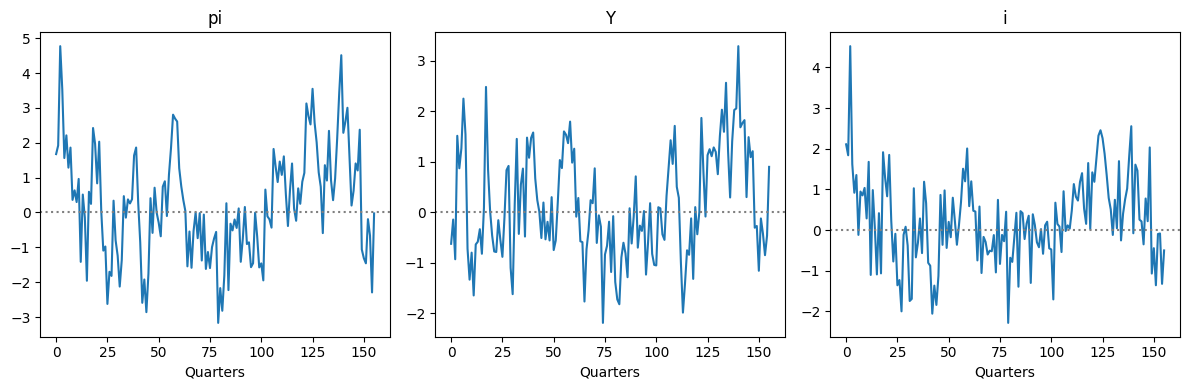

In [85]:
# Simulate series of pi, Y and i
T_sim = 156  # 39 years, as in the original SW (2007) sample N
# NOTE THIS IS SIMULATED DATA USING BKM METHOD. WE WILL USE THIS DATA LATER. 
data_simul = simulate(list(impulses.values()), outputs, T_sim)

#
def plot_timeseries(data_dict, dims, xlabel='Quarters', **kwargs):
    plt.figure(**kwargs)
    for i, (name, data) in enumerate(data_dict.items()):
        plt.subplot(*dims, i+1)
        plt.plot(data)
        plt.title(name)
        plt.xlabel(xlabel)
        plt.axhline(y=0, color='#808080', linestyle=':')
    plt.tight_layout()
    
plot_timeseries(data_simul, (1,3), figsize=(12, 4))



## Evaluating the log-likelihood
From here, we will explain step-by-step how to compute the log-likelihood, which can then be added to the log of the priors we specified to obtain the log-posterior, over which we will optimize to find the modal parameters.

First, we'll solve for the log-likelihood at the $\sigma$s and $\rho$s we've chosen so far.

### Step 1: compute the MA representation of outputs with respect to shocks
This step constructs the $MA(\infty)$ representation of the endogenous sequence $dX_t$ with respect to the exogenous shock $dZ_t$

In particular, if the $MA(\infty)$ representation of the exogenous shock is given by

$$
dZ_t = \sum_{s = 0}^\infty M^Z_s \epsilon_{t-s}
$$

Then under certainty equivalence, $dX_t$ follows

$$
dX_t = \sum_{s = 0}^\infty M^X_s \epsilon_{t - s}
$$

where the GE Jacobian, $\mathcal{G}$ gives us the mapping
$$
M^X = \mathcal{G}^{X, Z} M^Z
$$


We've actually already done this when we calculated `impulses`, which can also be viewed as the $MA(\infty)$ representation of the outcome variables of interest with respect to the shocks. So for this step, we don't need to do any more for now!

### Step 2: compute the covariance matrix of the model
Given $M^X$, we can then compute the covariance matrix of the endogenous variables via the formula (letting $Y$ denote the "observable" variables, as before)

$$
\text{Cov}(dX_t, dY_{t^\prime}) = \sum_{s = 0}^\infty M^X_s (M^Y_{s + t^\prime - t})'
$$

This process is automated by the SSJ function `sj.estimation.all_covariances`, which takes in the set of all $M$ s as a $T\times n_O \times n_Z$ array, where the first dimension is time, the second dimension is each output variable, and the third dimension is each shock. We can manually assemble it in this form:

In [86]:
M = np.empty((T, 3, 3))
for no, o in enumerate(outputs):  # outputs are endogenous
    for ns, s in enumerate(inputs): # inputs are shocks
        M[:, no, ns] = impulses[s][o] 

In [87]:
#M[:, 0, 0]

and then call it to get `Sigma`, which is a $T\times n_O \times n_O$ array, where in general `Sigma[s,o1,o2]` gives the covariance between output `o1` at time $t$ and output `o2` at time $t'=t+s$.

Note that this function also takes a second argument `sigmas` of the standard deviations of each shock, but we have already scaled our impulses by the standard deviation, so we should just use a vector of ones here:

In [88]:
Sigma = sj.estimation.all_covariances(M, np.ones(3)) # The second argument rescale by the standard deviation

In [89]:
help(sj.estimation.all_covariances)

Help on function all_covariances in module sequence_jacobian.estimation:

all_covariances(M, sigmas)
    Use Fast Fourier Transform to compute covariance function between O vars up to T-1 lags.
    
    See equation (108) in appendix B.5 of paper for details.
    
    Parameters
    ----------
    M      : array (T*O*Z), stacked impulse responses of nO variables to nZ shocks (MA(T-1) representation)
    sigmas : array (Z), standard deviations of shocks
    
    Returns
    ----------
    Sigma : array (T*O*O), covariance function between O variables for 0, ..., T-1 lags



The order of the Sigma function is given by the output order.

In [90]:
print(outputs)
print('This is the Covariance of Y (t=0) with Y (t=0) (i.e., the variance)', Sigma[0,1,1])
print('This is the Covariance of Y (t=0) with i (t=0)', Sigma[0,1,2])
print('This is the Covariance of Y (t=0) with i (t=1)', Sigma[1,1,2])

['pi', 'Y', 'i']
This is the Covariance of Y (t=0) with Y (t=0) (i.e., the variance) 1.0009947865529258
This is the Covariance of Y (t=0) with i (t=0) 0.030394286754977465
This is the Covariance of Y (t=0) with i (t=1) 0.27744063937986546


### Step 3: compute log-likelihood
Denote the stacked covariance matrix as $\mathbf{V}(\theta)$ to clarify that it is a function of the parameter vector, $\theta$.

The log-likelihood can then be computed, assuming Gaussian innovations to the shock processes, by stacking the data into the vector $\mathbf{Y}$ and calculating (ignoring constant terms that won't change with the data or parameters and only depend on dimension):

$$
\mathcal{L}(\mathbf{Y}; \theta) = -\frac{1}{2} \log \text{det} \mathbf{V}(\theta) - \frac{1}{2} \mathbf{Y}^\prime \mathbf{V}(\theta)^{-1} \mathbf{Y}
$$

This is implemented by the function `log_likelihood`, which takes as its second argument the `Sigma` matrix calculated above,  and as its first argument the `Y` array with the data for which we want to compute the log-likelihood. We'll manually assemble `Y`, where the first dimension is time and the second is the output:

In [91]:
# THIS IS THE SIMULATED DATA
Y = np.empty((T_sim, 3))
for no, o in enumerate(outputs):
    Y[:, no] = data_simul[o]
    


Then we'll apply the function. (It also takes in a third optional argument for measurement error, which we won't use.)

In [92]:
loglik = sj.estimation.log_likelihood(Y, Sigma)



### Step 4: adding the log-prior to the log-likelihood

This follows directly from Bayes' formula

$$
\log \pi(\theta; \mathbf{Y}) \propto \mathcal{L}(\mathbf{Y}; \theta) + \log \pi(\theta)
$$

To do this, we'll need to collapse our parameters (standard deviations and persistences) into a vector `theta`:

In [93]:
theta = np.array([sigmas['ishock'], rhos['ishock'], sigmas['X'], rhos['X'], sigmas['G'], rhos['G']]) # 

and then specify priors over these parameters (where each parameter has a prior given by a 3-tuple, with the family of distribution and two parameters describing that distribution for each—in this case just a uniform over $[0,2]$ for each):

In [94]:
# Specifying priors over the exogenous shock series parameters
priors = [('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2)]

and then use 

In [95]:
log_posterior = loglik + log_priors(theta, priors)

## Maximizing the posterior likelihood over these parameters
Now that we know how to calculate the log posterior likelihood given the data and shock process parameters, let's see if we can maximize this likelihood given the data - i.e. find the parameters at the posterior mode.

To do so, we need to consolidate the workflow above into a function that takes `theta` as an input and calculates the log posterior likelihood.

In [96]:
def log_likelihood(theta):
    # turn theta into dicts mapping input shocks to sigmas and rhos
    sigma_array, rho_array = theta.reshape(3, 2).T
    sigmas, rhos = dict(zip(inputs, sigma_array)), dict(zip(inputs, rho_array))
    
    # step 1: construct impulses to shocks, aka MA representation
    impulses = {}
    for i in inputs:
        own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)}
        impulses[i] = G @ own_shock
        
    # step 2: get covariances by building M array and calling .all_covariances()
    M = np.empty((T, 3, 3))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = impulses[s][o]
    
    Sigma = sj.estimation.all_covariances(M, np.ones(3))
    
    # step 3: compute log-likelihood
    loglik = sj.estimation.log_likelihood(Y, Sigma)
    
    # step 4: add log prior to get log posterior
    return loglik + log_priors(theta, priors)

Let's verify that this gives the same answer that we just found on the same `theta`:

In [97]:
log_likelihood(theta) == log_posterior

True

Now let's use a numerical optimization routine to find the `theta` that maximizes the log posterior. To make sure the optimizer stays in a reasonable subspace, we'll first need to put some bounds on each dimension of the `theta`:

In [98]:
bounds = [(0.05, 1.5), (0.01, 0.99), (0.05, 1.5), (0.01, 0.99), (0.05, 1.5), (0.01, 0.99)]

Then call `optimize.minimize`, asking to minimize the negative of the log likelihood, putting `0.8*theta` rather than the true parameter `theta` as our initial guess to make the optimizer's life a little more difficult. Turns out that it takes a bit more than a second:

In [99]:
%time result = optimize.minimize(lambda theta: -log_likelihood(theta), 0.8*theta, bounds=bounds)

CPU times: user 13min 37s, sys: 53.4 s, total: 14min 31s
Wall time: 1min 34s


In [100]:
theta_estimate = result.x
theta_estimate

array([0.98515254, 0.70587897, 0.53952631, 0.80743215, 0.19349643,
       0.66741568])

Maximum difference between estimated and true parameters not too large, so this seemed to work well!

In [101]:
np.max(np.abs(theta_estimate - theta))

0.03952631358255243

We could further check to make sure that the shock process parameters are well-identified by repeating this exercise on multiple simulated time series, making sure that the distribution of estimates we obtain has a peak near the true `theta`.